In [1]:
!pip install geehydro
!pip install rioxarray
!pip install fiona
!pip install rasterio
!pip install folium
!pip install geemap
!pip install cartopy
!pip install mapclassify
!pip install geoplot
!pip install pyreadr
!pip install pysal
!pip install contextily
!pip install geopandas
!pip install pyreadr

  Using cached geehydro-0.2.0-py2.py3-none-any.whl
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)
  Using cached google_cloud_core-2.4.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached proto_plus-1.24.0-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/455.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/455.1 kB ? eta -:--:--
    --------------------------------------- 10.2/455.1 kB ? eta -:--:--
    --------------------------------------- 10.2/455.1 kB ? eta -:--:--
   - ------------------------------------- 20.5/455.1 kB 108.9 kB/s eta 0:00:04
   - ------------------------------------- 20.5/455.1 kB 108.9 kB/s eta 0:00:

'apt' is not recognized as an internal or external command,
operable program or batch file.


     ---------------------------------------- 0.0/58.1 kB ? eta -:--:--
     ------- -------------------------------- 10.2/58.1 kB ? eta -:--:--
     ------------- ------------------------ 20.5/58.1 kB 162.5 kB/s eta 0:00:01
     ------------- ------------------------ 20.5/58.1 kB 162.5 kB/s eta 0:00:01
     ------------- ------------------------ 20.5/58.1 kB 162.5 kB/s eta 0:00:01
     -------------------------- ----------- 41.0/58.1 kB 163.4 kB/s eta 0:00:01
     -------------------------- ----------- 41.0/58.1 kB 163.4 kB/s eta 0:00:01
     -------------------------------------- 58.1/58.1 kB 191.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.5 MB 1.7 MB/s eta 0:00:15
   ---------------------------------------- 0.2/24.5 MB 1.7 MB/s eta 0:00:14
    --------------------------------------- 0.3/24.5 MB 2.1 MB/s eta 0:00:12
    --------------------------------------- 0.4/24.5 MB 2.2 MB/s eta 0:00:

In [1]:
#import all libraries
import os
import geopandas as gpd
import numpy as np, pandas as pd
import ee
import geemap
import pyreadr
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import requests
from io import BytesIO
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Authenticate and initialise Earth Engine API
try:
    ee.Initialize(project="ee-monthlyexposures")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-monthlyexposures")

In [4]:
# Check if notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
   IN_COLAB = False

In [5]:

if IN_COLAB:
    # Use the token from Github to clone the PRECISE repository with read/write access
    from IPython.display import clear_output; user="kudzaishezororo"; token=input();
    !git clone https://github.com/zororo2/heat.git

    clear_output()

ROI Bounding Box: [ 17.8831039 -34.1812126  35.6731    -13.6871846]
  Study ID Location ID               location  final_lat  final_long  \
0   MWI094    MWI094_1  Chilipa Health Centre   -14.7028     34.9739   
1   MWI094    MWI094_1  Chilipa Health Centre   -14.7028     34.9739   
2   MWI094    MWI094_1  Chilipa Health Centre   -14.7028     34.9739   
3   MWI094    MWI094_1  Chilipa Health Centre   -14.7028     34.9739   
4   MWI094    MWI094_1  Chilipa Health Centre   -14.7028     34.9739   

    date_only                  geometry  
0  2010-01-31  POINT (34.9739 -14.7028)  
1  2010-02-01  POINT (34.9739 -14.7028)  
2  2010-02-02  POINT (34.9739 -14.7028)  
3  2010-02-03  POINT (34.9739 -14.7028)  
4  2010-02-04  POINT (34.9739 -14.7028)  


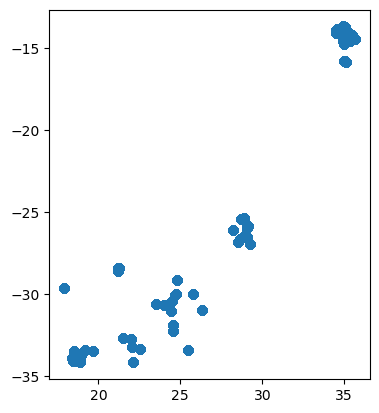

In [6]:
# Path to the local CSV file
local_file_path = 'C:/Users/user/OneDrive - Centre for Sexual Health HIV AIDS Research Zimbabwe/Heat/GIS/AOD/heat/data/heat.csv'

# Read the CSV file using pandas
df = pd.read_csv(local_file_path)

# Assuming your CSV has 'latitude' and 'longitude' columns
# Create a GeoDataFrame by converting the coordinates into Point geometries
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.final_long, df.final_lat))

# Plot the GeoDataFrame (optional)
gdf.plot()

# Get the bounding box of the points in the CSV
bbox = gdf.total_bounds  # total_bounds returns [minx, miny, maxx, maxy]

# Define the region of interest (ROI) as the bounding box of the points
roi = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

# Print the bounding box for verification
print(f"ROI Bounding Box: {bbox}")

# Print the first few rows of the GeoDataFrame for reference (optional)
print(gdf.head())

In [7]:
import ee
import pandas as pd
import os

# Initialize Earth Engine
ee.Initialize()

# Define the base directory where results will be saved
base_dir = 'C:/Users/user/OneDrive - Centre for Sexual Health HIV AIDS Research Zimbabwe/Heat/GIS/AOD/heat'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Step 1: Get the available AOD image dates for the predefined ROI
def get_available_aod_dates(start_date, end_date, roi):
    # Load MODIS AOD collection and filter by date and ROI
    collection = (ee.ImageCollection('MODIS/061/MCD19A2_GRANULES')
                  .filterDate(start_date, end_date)
                  .filterBounds(roi)
                  .select('Optical_Depth_047'))

    # Extract the unique dates with available AOD data
    available_dates = collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).distinct()
    available_dates = available_dates.getInfo()

    print(f"Available AOD dates: {available_dates}")
    return available_dates

# Define your ROI here (if not already defined elsewhere in your script)


# Get the available dates for a given date range
start_date = '2010-01-01'
end_date = '2018-01-31'
available_dates = get_available_aod_dates(start_date, end_date, roi)

# Save available dates to a CSV file for use in later steps
available_dates_path = os.path.join(base_dir, 'available_aod_dates.csv')
pd.DataFrame(available_dates, columns=['available_dates']).to_csv(available_dates_path, index=False)

print(f"Available AOD dates saved to: {available_dates_path}")


Available AOD dates: ['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-16', '2010-01-17', '2010-01-18', '2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28', '2010-01-29', '2010-01-30', '2010-01-31', '2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28', '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04', '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08', '2010-03-09', '2010-03-10', '2010-03-11'

In [8]:
import pandas as pd
import os

# Define the base directory
base_dir = 'C:/Users/user/OneDrive - Centre for Sexual Health HIV AIDS Research Zimbabwe/Heat/GIS/AOD/heat/data'

# Load the CSV file with the new 'date_only' column
csv_path = os.path.join(base_dir, 'heat.csv')
points_df = pd.read_csv(csv_path, low_memory=False)

# Load the available AOD dates from the CSV file (which has a column named 'available_dates')
available_dates_path = os.path.join(base_dir, 'available_aod_dates.csv')
available_dates_df = pd.read_csv(available_dates_path)

# Extract the list of available dates from the 'available_dates' column
available_dates = available_dates_df['available_dates'].tolist()

# Step 2: Filter data points by available AOD dates
def filter_points_by_available_dates(points_df, available_dates):
    # Filter the points dataframe based on available dates in the 'date_only' column
    filtered_points = points_df[points_df['date_only'].isin(available_dates)]
    return filtered_points

# Filter the points based on available AOD dates
filtered_points = filter_points_by_available_dates(points_df, available_dates)

# Save the filtered points to a new CSV file
filtered_points_path = os.path.join(base_dir, 'filtered_points.csv')
filtered_points.to_csv(filtered_points_path, index=False)

print(f"Filtered points saved to: {filtered_points_path}")


Filtered points saved to: C:/Users/user/OneDrive - Centre for Sexual Health HIV AIDS Research Zimbabwe/Heat/GIS/AOD/heat/data\filtered_points.csv


In [ ]:
import ee
import pandas as pd
import os
import concurrent.futures
import pickle
import logging

# Initialize logging for debugging
logging.basicConfig(level=logging.INFO)

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    logging.error("Error initializing Earth Engine: %s", e)
    raise e

# Load the filtered points dataset
base_dir = 'C:/Users/user/OneDrive - Centre for Sexual Health HIV AIDS Research Zimbabwe/Heat/GIS/AOD/heat/data'
filtered_points_path = os.path.join(base_dir, 'heat.csv')
filtered_points_df = pd.read_csv(filtered_points_path)

# Define the checkpoint file path
checkpoint_file = os.path.join(base_dir, 'checkpoint.pkl')

# Load the last completed batch from the checkpoint file
def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as file:
            return pickle.load(file)
    else:
        return 0  # Start from batch 0 if no checkpoint exists

# Save the current batch number to the checkpoint file
def save_checkpoint(checkpoint_file, batch_num):
    with open(checkpoint_file, 'wb') as file:
        pickle.dump(batch_num, file)

# Function to get AOD value for a specific point with a 3-day window
def get_aod_for_point(lat, lon, date, roi):
    point = ee.Geometry.Point([lon, lat])

    try:
        # Extend the date range by 1 day before and after
        start_date = ee.Date(date).advance(-1, 'day')
        end_date = ee.Date(date).advance(2, 'day')  # 3-day window

        # Load the MODIS AOD ImageCollection and filter by date and region (ROI)
        collection = (ee.ImageCollection('MODIS/061/MCD19A2_GRANULES')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi)
                      .select('Optical_Depth_047'))

        # Check if the collection contains any images
        if collection.size().getInfo() == 0:
            logging.warning(f"No AOD image available for date range: {start_date.format('YYYY-MM-dd').getInfo()} to {end_date.format('YYYY-MM-dd').getInfo()}")
            return None

        # Get the mean AOD value at the specific point location
        aod_image = collection.mean().clip(roi)
        aod_value = aod_image.reduceRegion(
            reducer=ee.Reducer.mean(),  # Use mean to get average over 3 days
            geometry=point,
            scale=500,
            maxPixels=1e9
        ).get('Optical_Depth_047').getInfo()

        return aod_value

    except Exception as e:
        logging.error(f"Error fetching AOD for point ({lat}, {lon}) on {date}: {e}")
        return None

# Step 1: Function to process a batch of data and save the batch
def process_batch(batch_num, batch_data, roi, base_dir):
    aod_values = []

    # Loop through each point in the batch and extract AOD if there's a matching image for the 'date_only'
    for index, row in batch_data.iterrows():
        lat = row['final_lat']
        lon = row['final_long']
        date = row['date_only']

        try:
            # Extract AOD value for the point at the specified date
            aod_value = get_aod_for_point(lat, lon, date, roi)
            logging.info(f"Batch {batch_num} - AOD value for point ({lat}, {lon}) on {date}: {aod_value}")
            aod_values.append(aod_value)
        except Exception as e:
            logging.error(f"Batch {batch_num} - Error retrieving AOD for point ({lat}, {lon}) on {date}: {e}")
            aod_values.append(None)

    # Add the AOD values to the batch data
    batch_data['AOD_value'] = aod_values

    # Save each batch to a separate CSV file
    batch_output_path = os.path.join(base_dir, f'batch_{batch_num}_aod_results.csv')
    batch_data.to_csv(batch_output_path, index=False)
    logging.info(f"Batch {batch_num} saved to {batch_output_path}")

    # Save checkpoint after successful batch processing
    save_checkpoint(checkpoint_file, batch_num)

    return batch_output_path

# Step 2: Parallel batch processing with checkpointing
def parallel_process_batches(filtered_points_df, roi, base_dir, batch_size=1000):
    num_batches = len(filtered_points_df) // batch_size + 1  # Calculate number of batches
    processed_batch_files = []

    # Load last completed batch number from checkpoint
    last_completed_batch = load_checkpoint(checkpoint_file)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        batch_futures = []

        # Split data into batches and submit each batch for parallel processing
        for batch_num in range(last_completed_batch, num_batches):  # Start from the last completed batch
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(filtered_points_df))
            batch_data = filtered_points_df.iloc[start_idx:end_idx]
            future = executor.submit(process_batch, batch_num, batch_data, roi, base_dir)
            batch_futures.append(future)

        # Collect results from all futures as they complete
        for future in concurrent.futures.as_completed(batch_futures):
            try:
                batch_file = future.result()
                processed_batch_files.append(batch_file)
                logging.info(f"Batch processing completed and saved: {batch_file}")
            except Exception as e:
                logging.error(f"Error processing batch: {e}")

    return processed_batch_files

# Step 3: Define region of interest (ROI)
# Here, you should define your region of interest based on the area you are analyzing.
# This is just an example using a small point-based ROI around Mozambique.

# Step 4: Start the batch processing
batch_size = 1000  # Set batch size to 1000 rows per batch (you can adjust this)
batch_files = parallel_process_batches(filtered_points_df, roi, base_dir, batch_size=batch_size)

# Step 5: Combine all batch results into a single CSV file
combined_data = pd.concat([pd.read_csv(batch_file) for batch_file in batch_files if batch_file], ignore_index=True)
final_output_path = os.path.join(base_dir, 'final_combined_aod_results.csv')
combined_data.to_csv(final_output_path, index=False)

logging.info(f"All batches processed and combined. Final result saved to: {final_output_path}")


INFO:root:Batch 1 - AOD value for point (-14.7028, 34.9739) on 2012-10-27: 290.3333333333333
INFO:root:Batch 1 - AOD value for point (-14.7028, 34.9739) on 2012-10-28: 331.3333333333333
INFO:root:Batch 1 - AOD value for point (-14.7028, 34.9739) on 2012-10-29: 331.3333333333333
INFO:root:Batch 1 - AOD value for point (-14.7028, 34.9739) on 2012-10-30: 433.5
INFO:root:Batch 18 - AOD value for point (-14.0902, 34.5448) on 2011-05-08: 307
INFO:root:Batch 0 - AOD value for point (-14.7028, 34.9739) on 2010-01-31: None
INFO:root:Batch 17 - AOD value for point (-14.3331596, 35.143396) on 2016-08-12: 332.25
INFO:root:Batch 1 - AOD value for point (-14.7028, 34.9739) on 2012-10-31: 554
INFO:root:Batch 2 - AOD value for point (-14.7028, 34.9739) on 2015-07-24: None
INFO:root:Batch 19 - AOD value for point (-14.0902, 34.5448) on 2014-02-01: 472
INFO:root:Batch 20 - AOD value for point (-14.0902, 34.5448) on 2016-10-28: 170.5
INFO:root:Batch 22 - AOD value for point (-13.962129, 35.1414284) on 20